In [ ]:
import pandas as pd

## Dask

Dask - пакет для параллельных вычислений на Python, совместимый с NumPy, Pandas, и scikit-learn. В Dask есть структура массивов, которая эквивалентна массивам в NumPy, датафреймы в Dask аналогичны датафреймам в Pandas, а Dask-ML – это аналог scikit-learn.

[Документация](https://docs.dask.org/en/stable/)

In [ ]:
import dask.dataframe as dd

NYC taxi cab data 2015

Apache Parquet — это бинарный, колоночно-ориентированный формат хранения больших данных

### Dask Arrays

In [ ]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
print('%.1f MB' % (ones_np.nbytes / (1024 * 1024)))

30.5 MB


In [ ]:
import dask.array as da

ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [ ]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [ ]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

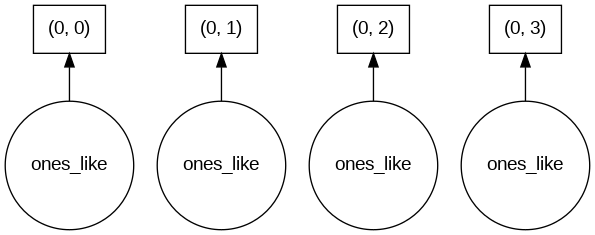

In [ ]:
ones.visualize()

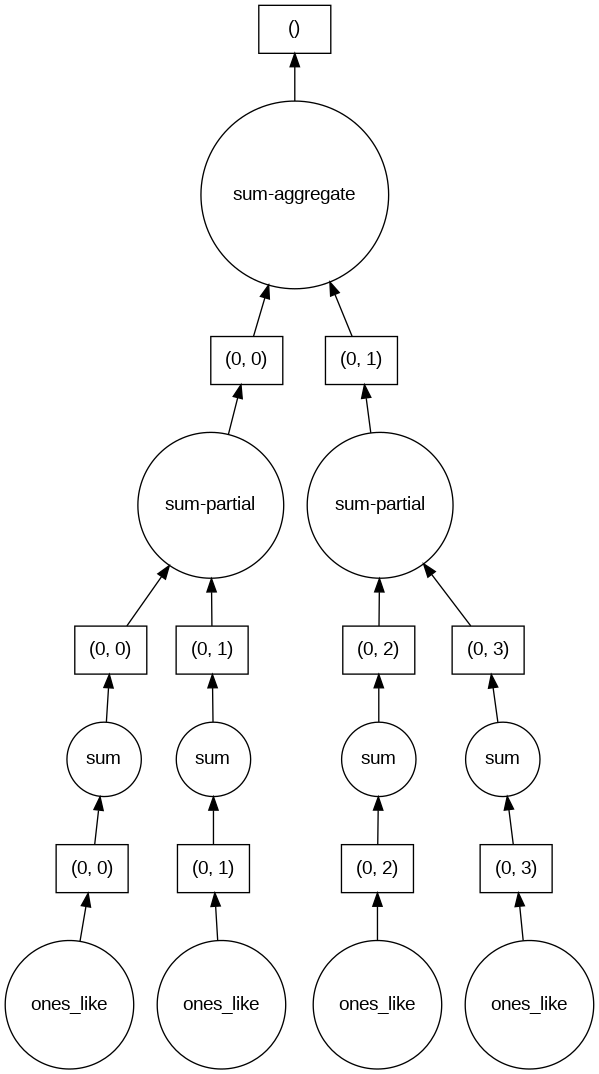

In [ ]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Возьмем побольше данных

In [ ]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones_like, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [ ]:
print('%.1f MB' % (big_ones.nbytes / (1024 * 1024)))

6103.5 MB


In [ ]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

np.float64(1.0)

In [ ]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=1)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(200000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [ ]:
import gc

del big_ones
del big_ones_reduce

gc.collect()

6806

### Dask DataFrame

In [ ]:
import kagglehub

path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

100%|██████████| 1.78G/1.78G [00:23<00:00, 80.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2


In [ ]:
!ls /root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2

yellow_tripdata_2015-01.csv  yellow_tripdata_2016-02.csv
yellow_tripdata_2016-01.csv  yellow_tripdata_2016-03.csv


In [ ]:
# Чтение всех CSV-файлов в папке /content/data
ddf = dd.read_csv("/root/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-*.csv",
                  usecols=["passenger_count", "tip_amount", "tpep_pickup_datetime"],
                  dtype={"passenger_count": "Int64", "tip_amount": "float64"},
                  parse_dates=["tpep_pickup_datetime"],
                  blocksize="100MB",
                  assume_missing=True)

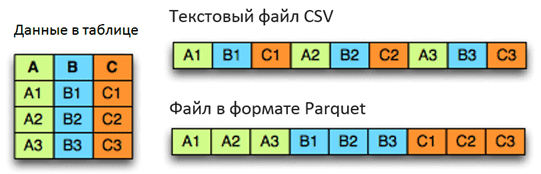

In [ ]:
ddf.head()

,tpep_pickup_datetime,passenger_count,tip_amount
0,2016-01-01,2,0.0
1,2016-01-01,5,0.0
2,2016-01-01,1,0.0
3,2016-01-01,1,0.0
4,2016-01-01,3,0.0


In [ ]:
len(ddf)

34499859

In [ ]:
type(ddf)

dask.dataframe.dask_expr._collection.DataFrame

Dask DataFrame состоит из множества объектов Pandas DataFrame/Series. Эти объекты pandas могут находиться на одном диске или на разных машинах.

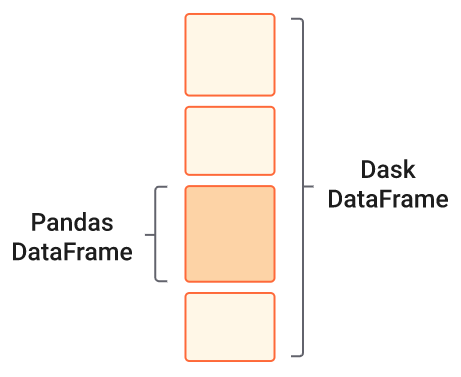

### Ленивые вычисления & граф вычислений

In [ ]:
result = ddf.groupby("passenger_count").tip_amount.mean()
result

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 5 expressions
Expr=((ArrowStringConversion(frame=FromMapProjectable(905f656))[['passenger_count', 'tip_amount']]).mean(observed=False, chunk_kwargs={'numeric_only': False}, aggregate_kwargs={'numeric_only': False}, _slice='tip_amount'))['tip_amount']

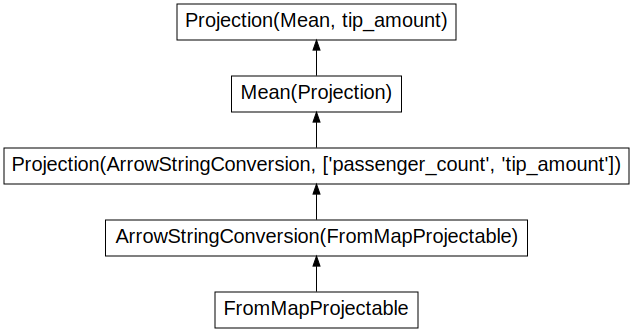

In [ ]:
result.visualize()

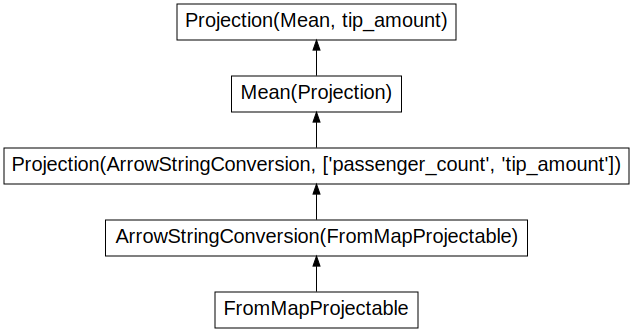

In [ ]:
result.visualize(filename='dask_graph.pdf')

In [ ]:
%%time

result.compute()

CPU times: user 4min 8s, sys: 16.9 s, total: 4min 25s
Wall time: 3min 51s


,tip_amount
passenger_count,
3,1.681968
7,3.840278
0,2.310103
2,1.784138
5,1.803779
8,4.678235
1,1.779241
4,1.581055
6,1.751171


### Merging Pandas DataFrames

In [ ]:
pd_df_1 = pd.DataFrame(
    {
        "Name": ["Azza", "Brandon", "Cedric", "Devonte", "Eli", "Fabio"],
        "Age": [29, 30, 21, 57, 32, 19]
    }
)
ddf_1 = dd.from_pandas(pd_df_1, npartitions=2)

pd_df_2 = pd.DataFrame(
    {
        "Name": ["Azza", "Cedric", "Fabio"],
        "City": ["Beirut", "Dublin", "Rosario"]
    }
)

joined = ddf_1.merge(pd_df_2, how="left", on=["Name"])
joined

,Name,Age,City
npartitions=2,,,
,string,int64,string
,...,...,...
,...,...,...


In [ ]:
joined.compute()

,Name,Age,City
0,Azza,29,Beirut
1,Brandon,30,<NA>
2,Cedric,21,Dublin
0,Devonte,57,<NA>
1,Eli,32,<NA>
2,Fabio,19,Rosario


### Dask Delayed

In [ ]:
import time

def inc(x):
    time.sleep(0.1)
    return x + 1

def dec(x):
    time.sleep(0.1)
    return x - 1

def add(x, y):
    time.sleep(0.2)
    return x + y

In [ ]:
%%timeit

x = inc(1)
y = dec(2)
z = add(x, y)
z

402 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import dask

inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [ ]:
%%timeit

x = inc(1)
y = dec(2)
z = add(x, y)

474 µs ± 170 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
x = inc(1)
y = dec(2)
z = add(x, y)

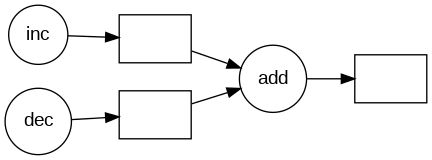

In [ ]:
z.visualize(rankdir='LR')

In [ ]:
%%timeit

z.compute()

304 ms ± 691 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
